# 🛡️ Phishing Email Detection V2 - DistilBERT Fine-tuning

**Project:** Hybrid AI Defense - Closing the Detection Gap Against AI-Generated Phishing  
**Author:** Ramkumar  
**Model:** DistilBERT (HuggingFace Transformers)  
**Dataset:** V2 - 10K Balanced Dataset (9,600 samples)

---

## 1. Setup & Installation

In [1]:
# Install required libraries
!pip install transformers datasets torch scikit-learn pandas numpy accelerate -q

In [2]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## 2. Upload Data

Upload your processed CSV files from `data/processed_v2/`:
- `train.csv` (7,679 samples)
- `validation.csv` (960 samples)
- `test.csv` (960 samples)

In [3]:
# Upload files (for Google Colab)
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv
Saving validation.csv to validation.csv


In [4]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"\nLabel distribution (train):")
print(train_df['label'].value_counts())
print(f"\nSource distribution (train):")
print(train_df['source'].value_counts())

Train: 7679 samples
Validation: 960 samples
Test: 961 samples

Label distribution (train):
label
0    3986
1    3693
Name: count, dtype: int64

Source distribution (train):
source
enron             2401
llm               1605
phishing_email    1176
nigerian_fraud     803
spamassasin        798
nazario            788
human              108
Name: count, dtype: int64


## 3. Prepare Dataset for Transformers

In [5]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Load DistilBERT tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Convert pandas to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7679
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 960
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 961
    })
})


In [6]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512  # DistilBERT max length
    )

# Tokenize all datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove text column (not needed for training)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

# Rename label to labels (required by Trainer)
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')

# Set format for PyTorch
tokenized_dataset.set_format('torch')

print("Tokenization complete!")
print(tokenized_dataset)

Map:   0%|          | 0/7679 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/961 [00:00<?, ? examples/s]

Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7679
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 960
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 961
    })
})


## 4. Load DistilBERT Model

In [7]:
from transformers import AutoModelForSequenceClassification

# Load pre-trained DistilBERT for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary: 0=Legit, 1=Phishing
    id2label={0: "LEGITIMATE", 1: "PHISHING"},
    label2id={"LEGITIMATE": 0, "PHISHING": 1}
)

print(f"Model loaded: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded: distilbert-base-uncased
Parameters: 66,955,010


## 5. Training Configuration

In [8]:
from transformers import TrainingArguments, Trainer

# Training arguments - V2 optimized for larger dataset
training_args = TrainingArguments(
    output_dir="./phishing_detector_v2",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    warmup_steps=500,
    fp16=True,  # Mixed precision for faster training
    report_to="none"
)

print("Training configuration:")
print(f"  - Epochs: {training_args.num_train_epochs}")
print(f"  - Batch size: {training_args.per_device_train_batch_size}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - Warmup steps: {training_args.warmup_steps}")

Training configuration:
  - Epochs: 3
  - Batch size: 16
  - Learning rate: 2e-05
  - Warmup steps: 500


In [9]:
# Metrics computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 6. Train the Model

In [10]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics
)

print("Starting training...")
print(f"Training samples: {len(tokenized_dataset['train'])}")
print(f"Validation samples: {len(tokenized_dataset['validation'])}")

Starting training...
Training samples: 7679
Validation samples: 960


In [11]:
# Train!
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.141696,0.097990,0.970833,0.952083,0.989177,0.970276
2,0.056363,0.046662,0.988542,0.984946,0.991342,0.988134
3,0.022121,0.052004,0.987500,0.984914,0.989177,0.987041


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=1440, training_loss=0.14470394249591562, metrics={'train_runtime': 388.2135, 'train_samples_per_second': 59.341, 'train_steps_per_second': 3.709, 'total_flos': 3051651462838272.0, 'train_loss': 0.14470394249591562, 'epoch': 3.0})

## 7. Evaluate on Test Set

In [12]:
# Evaluate on test set
print("Evaluating on test set...")
results = trainer.evaluate(tokenized_dataset['test'])

print("\n" + "="*50)
print("TEST RESULTS")
print("="*50)
print(f"Accuracy:  {results['eval_accuracy']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall:    {results['eval_recall']:.4f}")
print(f"F1 Score:  {results['eval_f1']:.4f}")

Evaluating on test set...



TEST RESULTS
Accuracy:  0.9917
Precision: 0.9892
Recall:    0.9935
F1 Score:  0.9914


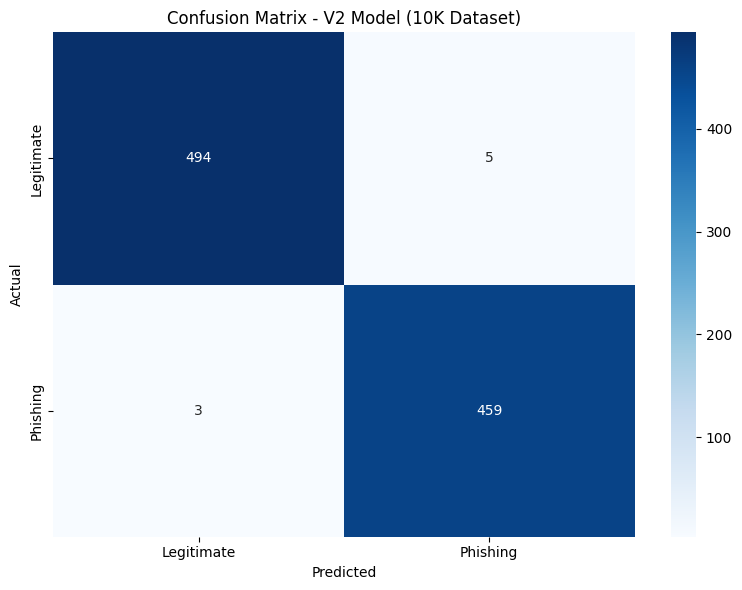


True Negatives (Legit→Legit): 494
False Positives (Legit→Phishing): 5
False Negatives (Phishing→Legit): 3
True Positives (Phishing→Phishing): 459


In [13]:
# Generate confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(tokenized_dataset['test'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix - V2 Model (10K Dataset)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives (Legit→Legit): {cm[0][0]}")
print(f"False Positives (Legit→Phishing): {cm[0][1]}")
print(f"False Negatives (Phishing→Legit): {cm[1][0]}")
print(f"True Positives (Phishing→Phishing): {cm[1][1]}")

## 8. Analyze by Source

In [14]:
# Analyze accuracy by source
print("Accuracy by Source:")
print("="*50)

for source in test_df['source'].unique():
    source_mask = test_df['source'] == source
    source_labels = test_df[source_mask]['label'].values
    source_preds = preds[source_mask]
    source_acc = accuracy_score(source_labels, source_preds)
    print(f"{source:20s}: {source_acc:.4f} ({source_mask.sum()} samples)")

Accuracy by Source:
enron               : 0.9827 (289 samples)
phishing_email      : 1.0000 (170 samples)
llm                 : 0.9949 (197 samples)
spamassasin         : 1.0000 (111 samples)
nigerian_fraud      : 0.9789 (95 samples)
nazario             : 1.0000 (90 samples)
human               : 1.0000 (9 samples)


## 9. Create Prediction Function

In [15]:
import torch

def predict_email(text, show_details=True):
    """Predict if an email is phishing or legitimate"""
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    )

    # Move to GPU if available
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred].item() * 100

    label = "PHISHING ⚠️" if pred == 1 else "LEGITIMATE ✅"

    if show_details:
        print(f"Prediction: {label}")
        print(f"Confidence: {confidence:.2f}%")

    return pred, confidence

## 10. Test with Sample Emails

In [16]:
# --- TEST 1: Phishing Email ---
print("="*50)
print("TEST 1: Phishing email")
print("="*50)
phishing_text = """Dear Customer,

We have detected unusual activity on your account. Your account access has been temporarily limited.
To restore full access, please verify your identity immediately by clicking the link below.

[URL]

If you do not verify within 24 hours, your account will be permanently suspended.
Please do not reply to this email.

Sincerely,
Security Team"""
predict_email(phishing_text)

# --- TEST 2: Legitimate Email ---
print("\n" + "="*50)
print("TEST 2: Legitimate email")
print("="*50)
legit_text = """Hi John,

I hope this email finds you well. I wanted to follow up on our discussion from last week about the quarterly report.

The numbers look good and I've attached the updated spreadsheet with the latest figures.
Let me know if you have any questions or need any clarifications.

Best regards,
Sarah
Marketing Department"""
predict_email(legit_text)

# --- TEST 3: Internal work email ---
print("\n" + "="*50)
print("TEST 3: Internal work email")
print("="*50)
legit_text2 = """Team,

Quick reminder that the office will be closed next Monday for the holiday.
Please make sure to complete your timesheet by Friday.

Thanks,
HR Team"""
predict_email(legit_text2)

# --- TEST 4: LLM-style phishing ---
print("\n" + "="*50)
print("TEST 4: LLM-style phishing")
print("="*50)
phishing_text2 = """Dear Valued Customer,

We regret to inform you that your payment method on file has been declined.
To avoid service interruption, please update your billing information immediately.

Click here to update your account: [URL]

This is an automated message. Failure to respond may result in account termination.

Thank you for your cooperation.
Customer Support Team"""
predict_email(phishing_text2)

TEST 1: Phishing email
Prediction: PHISHING ⚠️
Confidence: 99.81%

TEST 2: Legitimate email
Prediction: LEGITIMATE ✅
Confidence: 74.05%

TEST 3: Internal work email
Prediction: LEGITIMATE ✅
Confidence: 99.84%

TEST 4: LLM-style phishing
Prediction: PHISHING ⚠️
Confidence: 99.81%


(1, 99.8121440410614)

## 11. Test with Your Own Emails

In [17]:
# Test with your own emails!
my_emails = [
    """
    [Paste your first email here]
    """,
    """
    [Paste your second email here]
    """,
    """
    [Paste your third email here]
    """,
]

for i, email in enumerate(my_emails, 1):
    if email.strip() and "[Paste" not in email:
        print(f"\n{'='*50}")
        print(f"YOUR EMAIL #{i}")
        print(f"{'='*50}")
        predict_email(email)

## 12. Training Visualizations

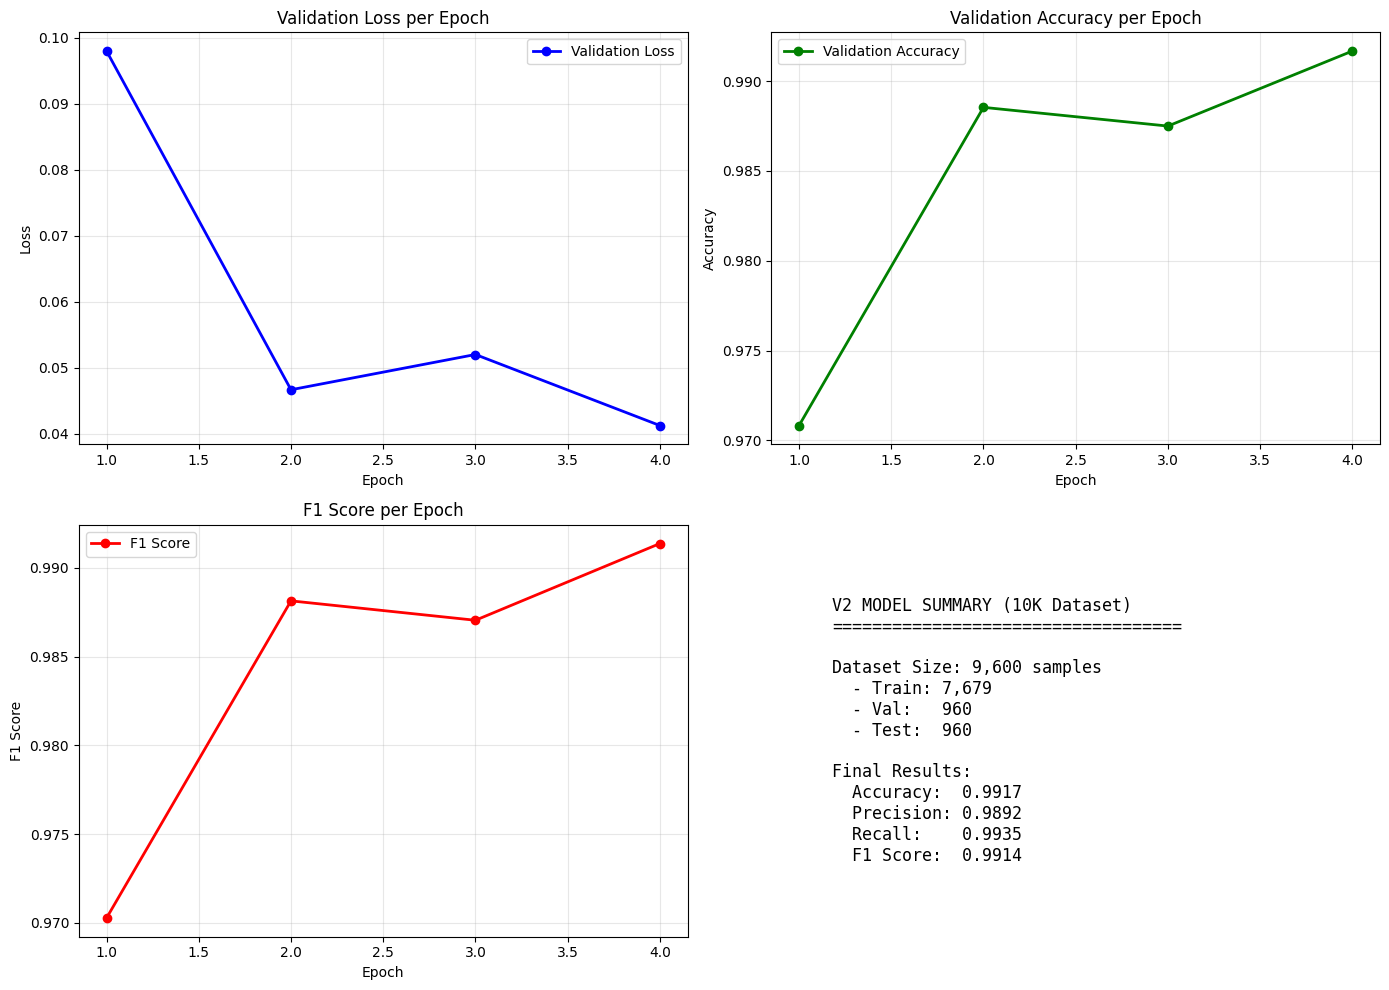

In [18]:
import matplotlib.pyplot as plt

# Get training history
history = trainer.state.log_history

# Extract metrics
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
epochs = list(range(1, len(eval_loss) + 1))

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Validation Loss
ax1 = axes[0, 0]
ax1.plot(epochs, eval_loss, 'b-o', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss per Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy
ax2 = axes[0, 1]
ax2.plot(epochs, eval_accuracy, 'g-o', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy per Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: F1 Score
ax3 = axes[1, 0]
ax3.plot(epochs, eval_f1, 'r-o', label='F1 Score', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score per Epoch')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
V2 MODEL SUMMARY (10K Dataset)
{'='*35}

Dataset Size: 9,600 samples
  - Train: 7,679
  - Val:   960
  - Test:  960

Final Results:
  Accuracy:  {results['eval_accuracy']:.4f}
  Precision: {results['eval_precision']:.4f}
  Recall:    {results['eval_recall']:.4f}
  F1 Score:  {results['eval_f1']:.4f}
"""
ax4.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
         verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig('training_metrics_v2.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Save Model

In [19]:
# Save model and tokenizer
MODEL_SAVE_PATH = './phishing_detector_model_v2'
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Model saved to: {MODEL_SAVE_PATH}")
print("Files saved:")
!ls -la {MODEL_SAVE_PATH}

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to: ./phishing_detector_model_v2
Files saved:
total 262276
drwxr-xr-x 2 root root      4096 Feb  8 16:40 .
drwxr-xr-x 1 root root      4096 Feb  8 16:40 ..
-rw-r--r-- 1 root root       787 Feb  8 16:40 config.json
-rw-r--r-- 1 root root 267832560 Feb  8 16:40 model.safetensors
-rw-r--r-- 1 root root       322 Feb  8 16:40 tokenizer_config.json
-rw-r--r-- 1 root root    711649 Feb  8 16:40 tokenizer.json
-rw-r--r-- 1 root root      5201 Feb  8 16:40 training_args.bin


In [20]:
# Zip and download model
import shutil

shutil.make_archive('phishing_detector_model_v2', 'zip', MODEL_SAVE_PATH)
print("Model zipped!")

# Download
from google.colab import files
files.download('phishing_detector_model_v2.zip')

Model zipped!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## ✅ V2 Training Complete!

**Next Steps:**
1. Download the trained model
2. Test with more real-world emails
3. Proceed to Week 2: Backend & URL Analysis